In [37]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor


primary_fuel_transformed
Other                       18859
Solar                       10664
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

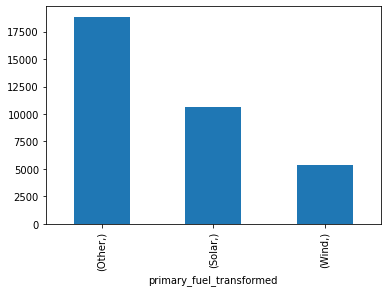

In [38]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v5_transformed_data_combined_with_nasa.csv", index_col=['index'])
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

csv_power_plants.drop(index_set_to_delete, inplace = True)
columns_to_combine = [
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [39]:
df_solar = df_transformed_combined[df_transformed_combined['primary_fuel_transformed']== "Solar"]

564
50


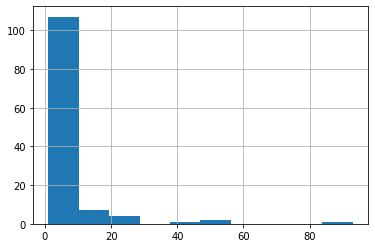

In [40]:
df_solar_alt = df_solar[df_solar['generation_gwh_2013'].notna()]
df_solar_alt['capacity_mw'].value_counts().hist(bins=10)
print(df_solar_alt[df_solar_alt['capacity_mw'] < 20]['capacity_mw'].count())
print(df_solar_alt.loc[(df_solar_alt['capacity_mw'] >= 20) & (df_solar_alt['capacity_mw'] < 100)]['capacity_mw'].count())


<AxesSubplot:>

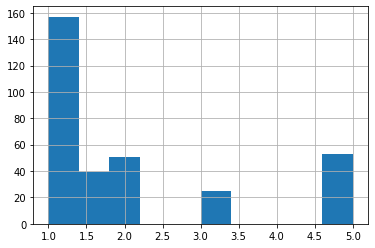

In [41]:

# df_solar_alt.loc[df_solar_alt['capacity_mw'] == (df_solar_alt['capacity_mw'].value_counts()>20)]
# indexes = df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()>20).index
# df_solar_alt['capacity_mw'].value_counts().values>20
# df_solar_alt.loc[indexes]['capacity_mw']
# df_solar_alt[df_solar_alt['capacity_mw'] == 145]
# df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)].capacity_mw
df_solar_alt_more_than_20 = df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)]
df_solar_alt_more_than_20['capacity_mw'].hist()

In [42]:
# utils.calculate_feature_mean_std(df_solar)

In [43]:
# columns_delete = df_solar.columns.str.contains('WS') | df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') |  df_solar.columns.str.contains('ANN') |  df_solar.columns.str.contains('LW') |  df_solar.columns.str.contains('WS10') | df_solar.columns.str.contains('MAX')
# columns_delete = df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') 
columns_delete = df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') 
# df_solar_2 = df_solar_alt_more_than_20.loc[:,~columns_delete]
df_solar_2 = df_solar_alt.loc[:,~columns_delete]

In [44]:
df_solar_2.columns

Index(['ANN_ALLSKY_SFC_LW_DWN_2013', 'ANN_ALLSKY_SFC_LW_UP_2013',
       'ANN_ALLSKY_SFC_SW_DIFF_2013', 'ANN_ALLSKY_SFC_SW_DNI_2013',
       'ANN_ALLSKY_SFC_SW_DWN_2013', 'ANN_ALLSKY_SFC_SW_UP_2013',
       'ANN_ALLSKY_SFC_SW_UP_MAX_2013', 'ANN_CLRSKY_SFC_SW_DIFF_2013',
       'ANN_CLRSKY_SFC_SW_DNI_2013', 'ANN_CLRSKY_SFC_SW_DWN_2013',
       'ANN_CLRSKY_SFC_SW_UP_2013', 'ANN_T2M_2013', 'ANN_WS10M_2013',
       'ANN_WS10M_MAX_AVG_2013', 'ANN_WS10M_RANGE_AVG_2013', 'ANN_WS50M_2013',
       'ANN_WS50M_MAX_AVG_2013', 'ANN_WS50M_RANGE_AVG_2013',
       'autumn_ALLSKY_SFC_LW_DWN_2013', 'autumn_ALLSKY_SFC_LW_UP_2013',
       'autumn_ALLSKY_SFC_SW_DIFF_2013', 'autumn_ALLSKY_SFC_SW_DNI_2013',
       'autumn_ALLSKY_SFC_SW_DWN_2013', 'autumn_ALLSKY_SFC_SW_UP_2013',
       'autumn_ALLSKY_SFC_SW_UP_MAX_2013', 'autumn_CLRSKY_SFC_SW_DIFF_2013',
       'autumn_CLRSKY_SFC_SW_DNI_2013', 'autumn_CLRSKY_SFC_SW_DWN_2013',
       'autumn_CLRSKY_SFC_SW_UP_2013', 'autumn_T2M_2013', 'autumn_WS10M_2013',
     

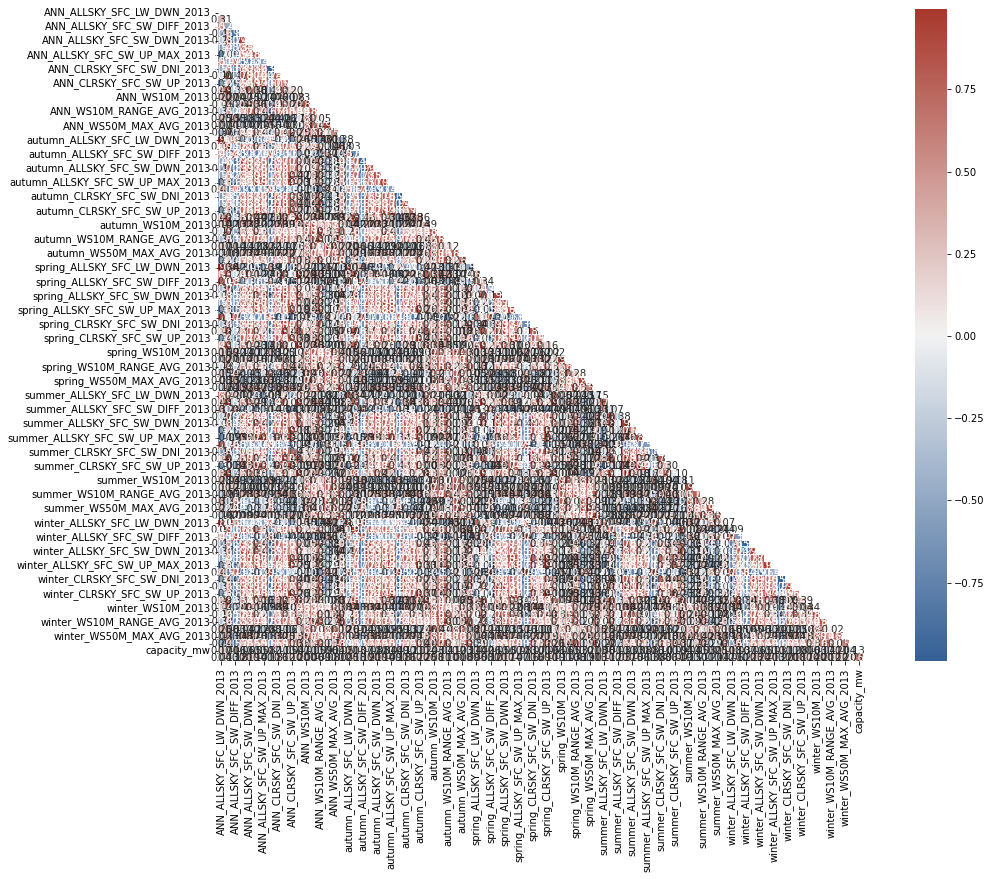

In [ ]:
utils.correlation_matrix(df_solar_2)

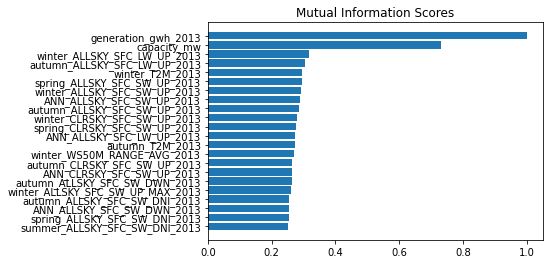

In [45]:
from matplotlib.pyplot import xlabel


# plt.bar(df_solar_2.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_solar_2.columns)
corr_matrix = df_solar_2.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh_2013'].sort_values(ascending=False)
target_correlations[target_correlations > .25]
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_mi_scores(target_correlations[target_correlations > .25])

/tmp/ipykernel_400/3444095128.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_solar_2.drop(columns=to_drop, inplace=True)


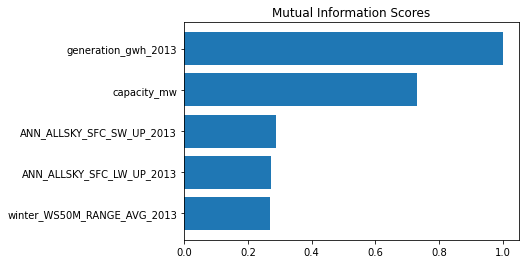

In [46]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_solar_2.drop(columns=to_drop, inplace=True)

corr_matrix = df_solar_2.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh_2013'].sort_values(ascending=False)
target_correlations[target_correlations > .25]
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_mi_scores(target_correlations[target_correlations > .25])

In [47]:
df_solar_2 = df_solar_2[target_correlations[target_correlations > .25].index]
df_solar_2

,generation_gwh_2013,capacity_mw,ANN_ALLSKY_SFC_SW_UP_2013,ANN_ALLSKY_SFC_LW_UP_2013,winter_WS50M_RANGE_AVG_2013
index,,,,,
794,0.847778,145.0,1.02,10.43,5.473333
24713,2.414610,1.9,0.52,8.79,4.003333
24715,1.528000,1.3,0.46,9.54,4.456667
24716,5.036000,3.8,0.52,8.79,3.553333
24719,2.741000,1.9,0.52,8.79,3.553333
...,...,...,...,...,...
34465,14.203000,10.0,0.72,8.67,4.213333
34491,1.341000,1.0,0.45,8.61,3.356667
34492,0.286000,5.0,0.57,9.06,3.450000


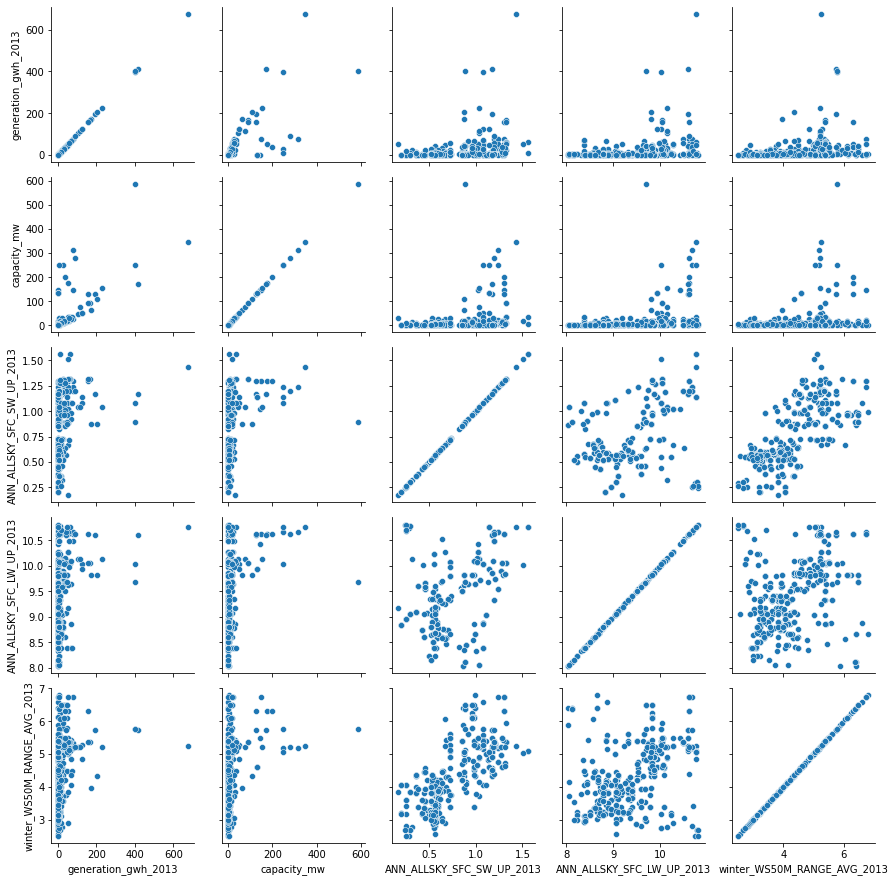

In [48]:
g = sns.PairGrid(df_solar_2)
g.map(sns.scatterplot)

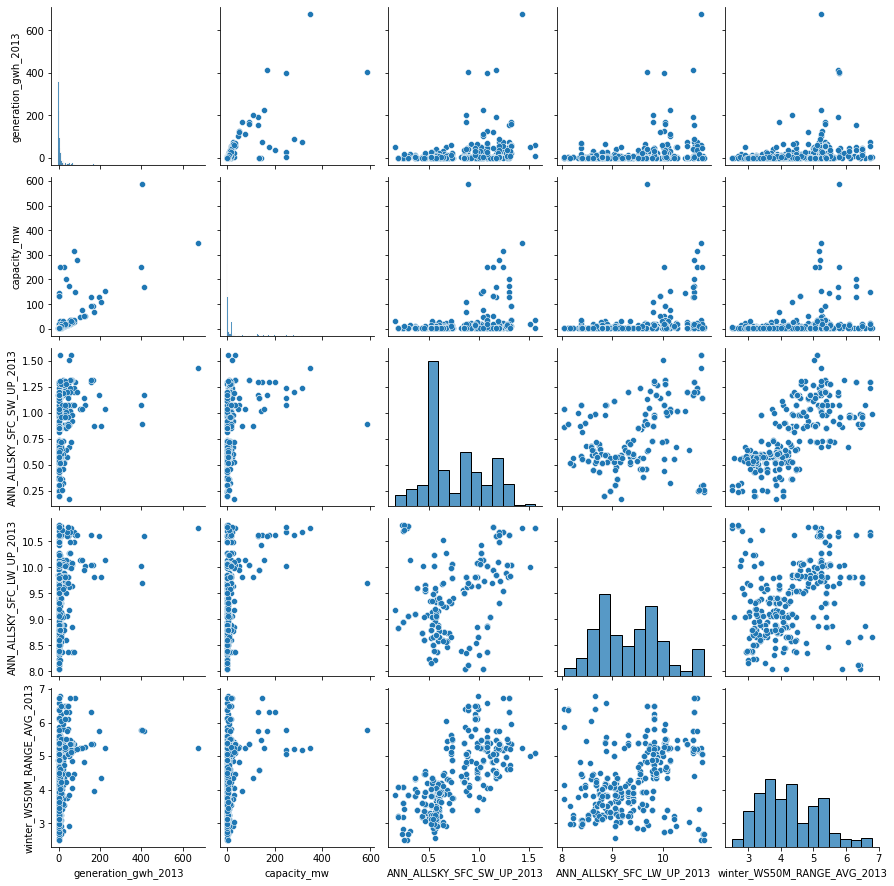

In [49]:
sns.pairplot(df_solar_2)

In [137]:
category = pd.cut(df_solar_2['generation_gwh_2013'], 6).cat.codes.rename('category')
df_solar_3 = pd.concat([df_solar_2, category], axis=1)

In [138]:
category.value_counts()

0    613
1      9
2      6
5      3
3      1
Name: category, dtype: int64

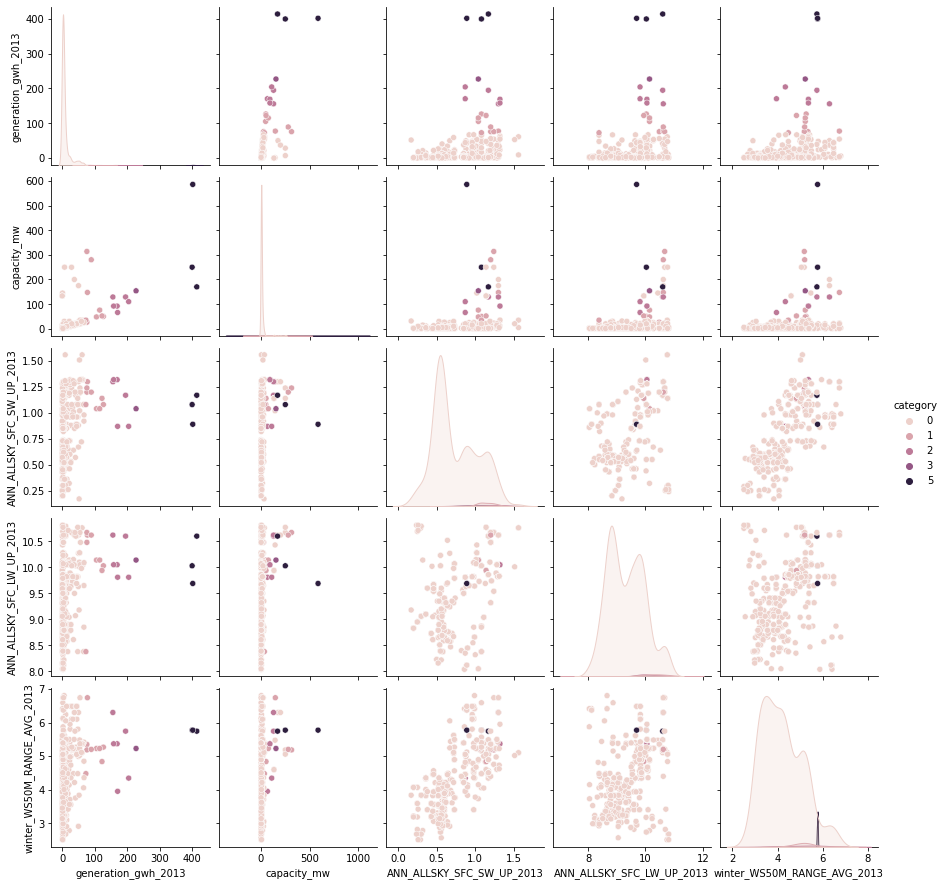

In [139]:
sns.pairplot(df_solar_3, hue='category')

<AxesSubplot:xlabel='capacity_mw', ylabel='generation_gwh_2013'>

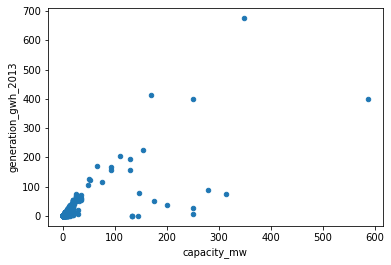

In [50]:
df_solar_2.plot.scatter(x='capacity_mw', y='generation_gwh_2013')

In [51]:
df_solar_2['generation_gwh_2013'].isna().sum()

0

In [157]:
# sns.pairplot(df_solar_2, hue="capacity_mw", height=2.5)

<AxesSubplot:>

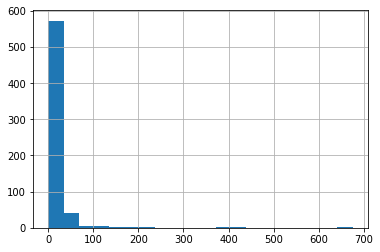

In [74]:
df_solar_2['generation_gwh_2013'].hist(bins=20)

542

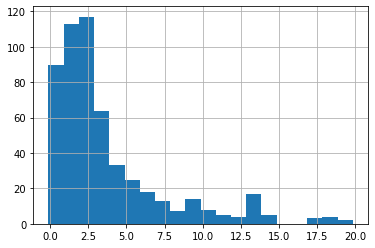

In [75]:
df_solar_2[df_solar_2['generation_gwh_2013'] < 20]['generation_gwh_2013'].hist(bins=20)
df_solar_2[df_solar_2['generation_gwh_2013'] < 20]['generation_gwh_2013'].count()

76

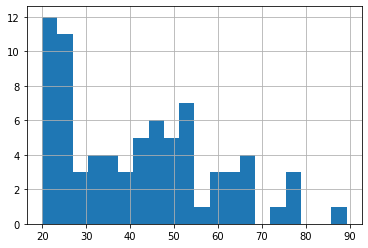

In [76]:
df_solar_2.loc[(df_solar_2['generation_gwh_2013'] >= 20) & (df_solar_2['generation_gwh_2013'] < 100)]['generation_gwh_2013'].hist(bins=20)
df_solar_2.loc[(df_solar_2['generation_gwh_2013'] >= 20) & (df_solar_2['generation_gwh_2013'] < 100)]['generation_gwh_2013'].count()

14

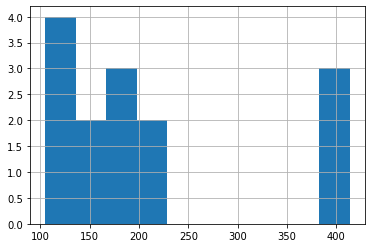

In [77]:
# df_solar_2[df_solar_2['generation_gwh_2013'] > 100]['generation_gwh_2013'].hist(bins=20)
# df_solar_2[df_solar_2['generation_gwh_2013'] > 100]['generation_gwh_2013'].count()
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 100) & (df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].hist()
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 100) & (df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()

In [78]:
df_solar_2[(df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()

632

In [83]:
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()

Int64Index([24873], dtype='int64', name='index')

In [87]:
df_solar_2.drop(df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)].index, inplace=True)

In [88]:
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()

0

In [89]:
a = df_solar_2[(df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()
b = df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()
f'{np.round(b/(a + b) * 100,2)}%'

'0.0%'

In [7]:
# df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 500)].copy()
df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 100)].copy()

In [17]:
# remove high values???
df_solar_2['capacity_mw'].sort_values(ascending= False)

index
20159    99.8
20910    99.8
20460    99.8
20380    99.8
1064     99.5
         ... 
16391     1.0
9787      1.0
32683     1.0
32684     1.0
32196     1.0
Name: capacity_mw, Length: 10316, dtype: float64

In [18]:
# df_solar.loc[18177, ["latitude", "longitude", "capacity_mw"]]

In [90]:
X = df_solar_2.drop(columns=['generation_gwh_2013'])
y = df_solar_2['generation_gwh_2013']

In [91]:
y.describe()

count    632.000000
mean      12.907273
std       36.729529
min       -0.116000
25%        1.651725
50%        2.812500
75%        7.949000
max      413.611000
Name: generation_gwh_2013, dtype: float64

In [14]:
counted = y.value_counts().sort_values(ascending=False)
counted.iloc[:3]#filter by value dataframe

5.0     1030
20.0     626
10.0     606
Name: capacity_mw, dtype: int64

In [92]:
X = X.reindex(sorted(X.columns), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 0)

# DECISION TREE REGRESSOR

In [93]:

# Define model. Specify a number for random_state to ensure same results each run
tree_model = DecisionTreeRegressor(random_state=1)

# Fit model
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [94]:
y_pred = tree_model.predict(X_test)

In [95]:

print(mean_absolute_error(y_test, y_pred))

9.522819900262466


In [96]:
tree_model.score(X_test, y_test)

0.698590298006261

<AxesSubplot:>

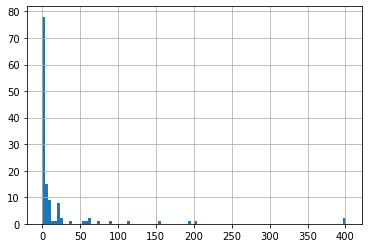

In [97]:
y_test.hist(bins=100)

<AxesSubplot:>

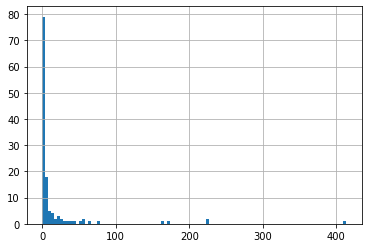

In [98]:
pd.Series(y_pred).hist(bins=100)

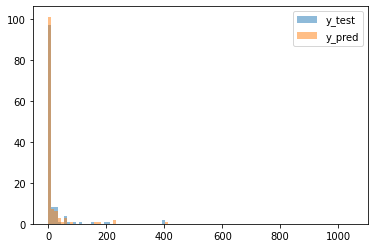

In [99]:
bins = np.linspace(0, 1050, 100)

plt.hist(y_test, bins, alpha=0.5, label='y_test')
plt.hist(y_pred, bins, alpha=0.5, label='y_pred')
plt.legend(loc='upper right')
plt.show()

(array([[115.,   5.,   2.,   1.,   2.,   0.,   0.,   0.,   0.,   2.],
        [116.,   6.,   0.,   1.,   1.,   2.,   0.,   0.,   0.,   1.]]),
 array([-1.160000e-01,  4.125670e+01,  8.262940e+01,  1.240021e+02,
         1.653748e+02,  2.067475e+02,  2.481202e+02,  2.894929e+02,
         3.308656e+02,  3.722383e+02,  4.136110e+02]),
 <a list of 2 BarContainer objects>)

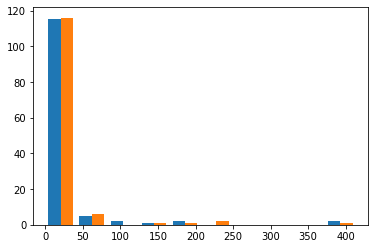

In [100]:
plt.hist([y_test, y_pred])

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='generation_gwh_2013', ylabel='generation_gwh_2013'>

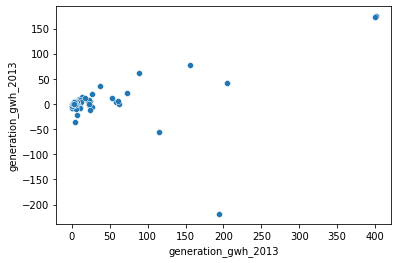

In [101]:
residuals = y_test - y_pred
sns.scatterplot(y_test, residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='generation_gwh_2013', ylabel='generation_gwh_2013'>

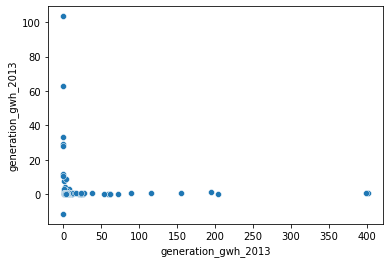

In [102]:
ap_residuals = np.abs(residuals) / y_test

sns.scatterplot(y_test, ap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='generation_gwh_2013', ylabel='generation_gwh_2013'>

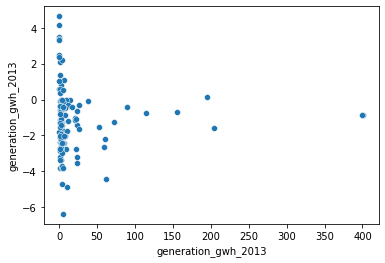

In [103]:
lap_residuals = np.log(ap_residuals)
sns.scatterplot(y_test, lap_residuals)

In [105]:
plt.displot(y_test, lap_residuals)

TypeError: displot() takes from 0 to 1 positional arguments but 2 were given

ValueError: supplied range of [-6.375663457422979, inf] is not finite

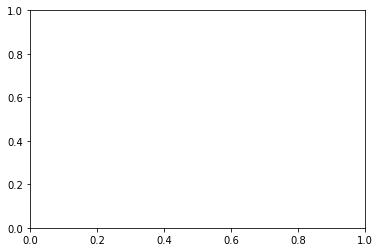

In [104]:
plt.hist(lap_residuals, bins=100, density=1, histtype='step', cumulative=True)

# RANDOM FOREST REGRESSOR

In [106]:
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

8.522380385290905


In [107]:
rf_model.score(X_test, y_test)

0.7274977970233947

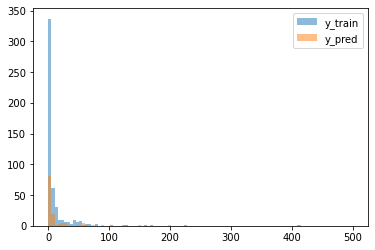

In [108]:
bins = np.linspace(0, 500, 100)

plt.hist(y_train, bins, alpha=0.5, label='y_train')
plt.hist(y_pred, bins, alpha=0.5, label='y_pred')
plt.legend(loc='upper right')
plt.show()

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='generation_gwh_2013', ylabel='generation_gwh_2013'>

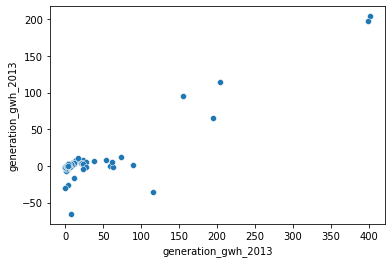

In [109]:
residuals = y_test - y_pred
ap_residuals = np.abs(residuals) / y_test
lap_residuals = np.log(ap_residuals)

sns.scatterplot(y_test, residuals)


/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='generation_gwh_2013', ylabel='generation_gwh_2013'>

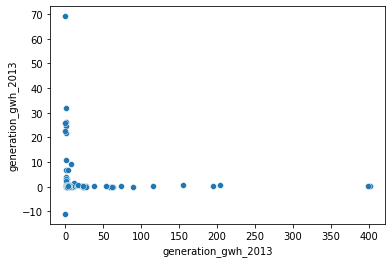

In [110]:

sns.scatterplot(y_test, ap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='generation_gwh_2013', ylabel='generation_gwh_2013'>

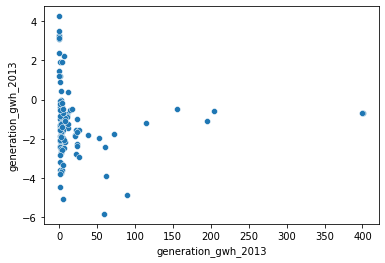

In [111]:

sns.scatterplot(y_test, lap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/matplotlib/transforms.py:2052: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/matplotlib/transforms.py:396: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


<BarContainer object of 127 artists>

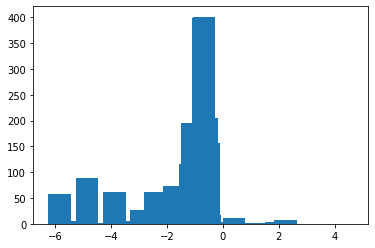

In [118]:
plt.bar(lap_residuals,y_test)

ValueError: supplied range of [-5.827033026837882, inf] is not finite

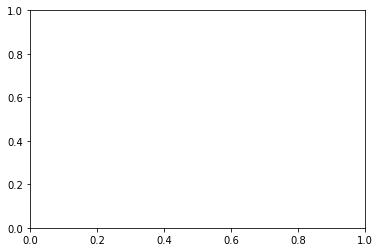

In [112]:
plt.hist(lap_residuals, bins=100, density=1, histtype='step', cumulative=True)

# LASSO

In [113]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train,y_train)

ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train,y_train)

linreg_model = LinearRegression()
linreg_model.fit(X_train,y_train)

y_pred = lasso_model.predict(X_test)
print("Lasso")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(lasso_model.score(X_test, y_test))

y_pred = linreg_model.predict(X_test)
print("Linear Regression")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(linreg_model.score(X_test, y_test)
)
y_pred = ridge_model.predict(X_test)
print("Ridge")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(ridge_model.score(X_test, y_test))

Lasso
14.063902556530767
1201.5999719039862
0.641014536331731
Linear Regression
14.075081403151602
1202.2217411485203
0.6408287789034998
Ridge
14.062268416515405
1201.40923947806
0.6410715188300322
